# Machine Learning Analysis without Outliers

## Overview

The goal of this machine learning analysis is to develop a predictive model for estimating real estate listing prices in Utah. We’ll employ a variety of regression techniques, including Linear Regression, Decision Trees, and Ensemble methods, to assess model accuracy and identify the best predictors of property price. By refining the model with features such as price-per-square-foot and property age, we aim to provide accurate and actionable insights that real estate professionals, investors, and analysts can use to gauge property values effectively.

As a reminder goal is to find out:

- Which features best predict listing prices.
- How accurately different models can predict these prices.
- How much we can improve accuracy by tuning models.

## Machine Learning Analysis Questions
- What are the best predictors of listing price among the property features?
- How accurately can we predict the list price based on property attributes?
- How do different regression models compare in predicting the listing price?
- What are the residuals and their distribution for the best-performing model?
- Does model performance improve significantly with hyperparameter tuning?

### Data Preparation

Data preparation is a crucial step where we get our data ready for modeling. This includes dividing the data into training and testing sets, scaling (or resizing) the numerical data, and encoding (or converting) the categorical data (like property type) into a format the model can understand.

In [11]:
#Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [12]:
#Loading the Clean & Transformed Data
path = ('../data/cleaned_real_estate_utah.csv')
cleanedrs_data = pd.read_csv(path)

### Impact of Outliers 

In machine learning, outliers can significantly impact model performance, especially for certain algorithms. Removing or handling them correctly can help improve prediction accuracy.

In [13]:
cleanedrs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4440 entries, 0 to 4439
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   type                              4440 non-null   object 
 1   text                              4440 non-null   object 
 2   year_built                        4440 non-null   float64
 3   beds                              4440 non-null   float64
 4   baths                             4440 non-null   float64
 5   baths_full                        4440 non-null   float64
 6   baths_half                        4440 non-null   float64
 7   garage                            4440 non-null   float64
 8   lot_sqft                          4440 non-null   float64
 9   sqft                              4440 non-null   float64
 10  stories                           4440 non-null   float64
 11  lastSoldOn                        4440 non-null   object 
 12  listPr

In [14]:
#Removing Outliers using IQR (Pulled from Kaggle)
def remove_outliers_iqr(cleanedrs_data, columns):
    """
    Remove outliers from the specified columns in the DataFrame using the IQR technique.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): A list of column names to check for outliers.

    Returns:
    pd.DataFrame: A DataFrame with outliers removed.
    """
    for column in columns:
        Q1 = cleanedrs_data[column].quantile(0.25)
        Q3 = cleanedrs_data[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        cleanedrs_data = cleanedrs_data[(cleanedrs_data[column] >= lower_bound) & (cleanedrs_data[column] <= upper_bound)]

    return cleanedrs_data

In [15]:
columns_to_check = ['beds', 'baths', 'sqft', 'listPrice', "lot_sqft"]
cleanedrs_data = remove_outliers_iqr(cleanedrs_data, columns_to_check)

In [16]:
cleanedrs_data.reset_index(drop=True, inplace=True)
cleanedrs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2858 entries, 0 to 2857
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   type                              2858 non-null   object 
 1   text                              2858 non-null   object 
 2   year_built                        2858 non-null   float64
 3   beds                              2858 non-null   float64
 4   baths                             2858 non-null   float64
 5   baths_full                        2858 non-null   float64
 6   baths_half                        2858 non-null   float64
 7   garage                            2858 non-null   float64
 8   lot_sqft                          2858 non-null   float64
 9   sqft                              2858 non-null   float64
 10  stories                           2858 non-null   float64
 11  lastSoldOn                        2858 non-null   object 
 12  listPr

### Defining X and y
In the data preparation for machine learning, we need to specify:

- X: The features or independent variables, which will include all relevant property attributes that may predict listing price (like square footage, number of bedrooms, and any encoded columns for categorical features).
- y: The target or dependent variable, which in this case is the listing price (listPrice), as we are trying to predict this value.

In [17]:
# Define target variable y as the listing price
y = cleanedrs_data['listPrice']

# Define feature matrix X, selecting only the relevant columns
# Here we drop columns that aren't needed for prediction like 'listPrice' and the original categorical columns
X = cleanedrs_data.drop([
    'listPrice',           # Target variable
    'type',                # Original categorical column
    'status',              # Original categorical column
    'text',                # Text data
    'lastSoldOn',          # Date information, potentially unnecessary
    'type_comparison',     # Non-numeric comparison column
], axis=1)

We set y to be listPrice, as this is our target variable.
X includes all features, but excludes listPrice (since it’s our target) and the original unencoded columns for type and status, as we have already created encoded versions

### Splitting Data into Training & Testing Sets:
- The training set is used to teach the model.
- The testing set checks if the model can accurately predict new, unseen data.

In [18]:
# Split the data (assuming 'X' are the features and 'y' is the target variable, listPrice)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We use 80% of our data for training and 20% for testing, which is common for predictive modeling.

### Scaling Numerical Features:
- To help the model perform better, we scale features like square footage, which might have a large range.

In [19]:
# Scale numerical features (fit on train data, transform on both train and test data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling makes sure that big numbers (like 2000 sqft) don’t overpower smaller numbers, helping the model learn relationships more effectively.

### Encoding Categorical Features
Since we handled encoding earlier, here’s how to confirm we’re using the processed data:

type_comparison and any additional one-hot columns we created for type are now in X.
status_encoded is also in X, which contains ordinal encoding for the status column.
If we did these steps earlier, we don’t need to encode type or status again. We can proceed directly to model training.

In [20]:
# #Example to Encode Categorical Features (already completed in data cleaning step 2.4)
# # Encode categorical features
# categorical_features = ['propertyType', 'status']
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(), categorical_features)],
#     remainder='passthrough')

# X_train_prepared = preprocessor.fit_transform(X_train)
# X_test_prepared = preprocessor.transform(X_test)

Encoding converts text categories into numbers so the model can process them.

In [21]:
# Convert scaled data back to DataFrames with the original column names for easy reference
X_train_prepared = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_prepared = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Final Structure of X and y
This section ensures that we’re only using the encoded columns, without redundancies:

In [22]:
# Print a summary of X and y to verify
print("Features (X):", X.columns)
print("Target (y):", y.name)

Features (X): Index(['year_built', 'beds', 'baths', 'baths_full', 'baths_half', 'garage',
       'lot_sqft', 'sqft', 'stories', 'sold_year', 'sold_month', 'type_condo',
       'type_condo_townhome', 'type_condo_townhome_rowhome_coop',
       'type_condos', 'type_farm', 'type_land', 'type_mobile', 'type_other',
       'type_single_family', 'type_townhomes', 'type_townhouse',
       'status_encoded'],
      dtype='object')
Target (y): listPrice


This step confirms the columns in X match our expectations for the features we want to include and are ready for training.

By following these adjustments, our machine learning model should now use the prepared data directly, with all required encoding already applied. This approach keeps the workflow clean and efficient without duplicating steps.

### Modeling
In this step, we’ll train several models to see which ones perform best. A “shotgun approach” means we test many models to find which gives the best initial results.

### Train Multiple Regression Models:
- We’ll train six to eight base models and evaluate their performance. Common models include:
  - Linear Regression
  - Decision Tree Regressor
  - Random Forest Regressor
  - Gradient Boosting Regressor
  - Ridge and Lasso Regression (for regularization)
  - K-Nearest Neighbors Regressor

In [23]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

# Fit each model on the training data and store the results
results = {}
for model_name, model in models.items():
    model.fit(X_train_prepared, y_train)
    results[model_name] = model.score(X_test_prepared, y_test)
    print(f"{model_name} score: {results[model_name]}")

Linear Regression score: 0.5954785535268682
Ridge Regression score: 0.5936141241222923


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.369e+11, tolerance: 1.070e+10
  model = cd_fast.enet_coordinate_descent(


Lasso Regression score: 0.593592395639175
Decision Tree score: 0.4417947116744324
Random Forest score: 0.6294803498982293
Gradient Boosting score: 0.6267016512326129
K-Nearest Neighbors score: 0.5896317604827508


We train and evaluate each model, storing each model’s score to compare which predicts listing prices best.

### Cross-Validation:
- Cross-validation gives a more reliable estimate of model performance by testing on different subsets of the training data.

In [24]:
# Cross-validate for each model
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train_prepared, y_train, cv=5)
    print(f"{model_name} Cross-Validation Score: {cv_scores.mean()}")

Linear Regression Cross-Validation Score: -5.602364997140645e+23
Ridge Regression Cross-Validation Score: 0.6346991857135033
Lasso Regression Cross-Validation Score: 0.6346467917879364


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.238e+11, tolerance: 8.524e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e+12, tolerance: 8.675e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Decision Tree Cross-Validation Score: 0.44503086903025074
Random Forest Cross-Validation Score: 0.6504587799418824
Gradient Boosting Cross-Validation Score: 0.6584404467453725
K-Nearest Neighbors Cross-Validation Score: 0.5972124681217272


### Evaluation:
Now, we assess each model’s accuracy using metrics that measure how close the predictions are to actual prices.

Evaluation Metrics:

- Mean Absolute Error (MAE) and Mean Squared Error (MSE) show prediction accuracy. Lower values mean better performance.
- R-squared measures how well the model explains the price variation; closer to 1 is better.

In [25]:
# Define and train the Gradient Boosting model
best_model = GradientBoostingRegressor()  
best_model.fit(X_train_prepared, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test_prepared)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 90475.15458259117
Mean Squared Error: 16316844030.432077
R-squared: 0.6260565650171691


### Hyperparameter Tuning:
- We improve the model by adjusting its settings, like the number of trees in a forest. This helps the model learn better patterns.


In [26]:
# Tune hyperparameters for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train_prepared, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'n_estimators': 200}


### Linear Regression, Ridge Regression, Lasso Regression
While these models don't have many hyperparameters to tune, Ridge and Lasso have a hyperparameter for regularization strength (alpha). For Linear Regression, no hyperparameter tuning is needed, but for Ridge and Lasso, we can tune alpha.

In [27]:
# Tuning hyperparameters for Ridge Regression
param_grid_ridge = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}
grid_search_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5)
grid_search_ridge.fit(X_train_prepared, y_train)
print("Best Parameters for Ridge:", grid_search_ridge.best_params_)

# Tuning hyperparameters for Lasso Regression
param_grid_lasso = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5)
grid_search_lasso.fit(X_train_prepared, y_train)
print("Best Parameters for Lasso:", grid_search_lasso.best_params_)

Best Parameters for Ridge: {'alpha': 10}


/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.236e+11, tolerance: 8.524e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e+12, tolerance: 8.675e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/cohort_env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Best Parameters for Lasso: {'alpha': 100}


### Decision Tree Regressor 
The Decision Tree Regressor has hyperparameters like max_depth, min_samples_split, and min_samples_leaf that can be tuned.


In [28]:
# Tuning hyperparameters for Decision Tree
param_grid_tree = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_search_tree = GridSearchCV(DecisionTreeRegressor(), param_grid_tree, cv=5)
grid_search_tree.fit(X_train_prepared, y_train)
print("Best Parameters for Decision Tree:", grid_search_tree.best_params_)

Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}


### K-Nearest Neighbors (KNN) 
For KNN, the hyperparameter n_neighbors can be tuned. We might also want to tune weights (whether the algorithm should use uniform or distance-based weighting) and metric.

In [29]:
# Tuning hyperparameters for K-Nearest Neighbors (KNN)
param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5)
grid_search_knn.fit(X_train_prepared, y_train)
print("Best Parameters for KNN:", grid_search_knn.best_params_)

Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}


### Gradient Boosting Regressor
For Gradient Boosting, we can tune n_estimators, learning_rate, max_depth, and other parameters to improve the model’s performance.

In [30]:
# Tuning hyperparameters for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search_gb = GridSearchCV(GradientBoostingRegressor(), param_grid_gb, cv=5)
grid_search_gb.fit(X_train_prepared, y_train)
print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)

Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [31]:
# Re-train each model with the best hyperparameters

# For Ridge
best_ridge = Ridge(alpha=grid_search_ridge.best_params_['alpha'])
best_ridge.fit(X_train_prepared, y_train)

# For Lasso
best_lasso = Lasso(alpha=grid_search_lasso.best_params_['alpha'])
best_lasso.fit(X_train_prepared, y_train)

# For Decision Tree
best_tree = DecisionTreeRegressor(
    max_depth=grid_search_tree.best_params_['max_depth'],
    min_samples_split=grid_search_tree.best_params_['min_samples_split'],
    min_samples_leaf=grid_search_tree.best_params_['min_samples_leaf']
)
best_tree.fit(X_train_prepared, y_train)

# For KNN
best_knn = KNeighborsRegressor(
    n_neighbors=grid_search_knn.best_params_['n_neighbors'],
    weights=grid_search_knn.best_params_['weights'],
    metric=grid_search_knn.best_params_['metric']
)
best_knn.fit(X_train_prepared, y_train)

# For Gradient Boosting
best_gb = GradientBoostingRegressor(
    n_estimators=grid_search_gb.best_params_['n_estimators'],
    learning_rate=grid_search_gb.best_params_['learning_rate'],
    max_depth=grid_search_gb.best_params_['max_depth']
)
best_gb.fit(X_train_prepared, y_train)

GradientBoostingRegressor()

In [32]:
# For Ridge
y_pred_ridge = best_ridge.predict(X_test_prepared)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"Ridge Model - MAE: {mae_ridge}, MSE: {mse_ridge}, R2: {r2_ridge}")

# For Lasso
y_pred_lasso = best_lasso.predict(X_test_prepared)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Lasso Model - MAE: {mae_lasso}, MSE: {mse_lasso}, R2: {r2_lasso}")

# For Decision Tree
y_pred_tree = best_tree.predict(X_test_prepared)
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print(f"Decision Tree Model - MAE: {mae_tree}, MSE: {mse_tree}, R2: {r2_tree}")

# For KNN
y_pred_knn = best_knn.predict(X_test_prepared)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print(f"KNN Model - MAE: {mae_knn}, MSE: {mse_knn}, R2: {r2_knn}")

# For Gradient Boosting
y_pred_gb = best_gb.predict(X_test_prepared)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f"Gradient Boosting Model - MAE: {mae_gb}, MSE: {mse_gb}, R2: {r2_gb}")

Ridge Model - MAE: 95894.45696912776, MSE: 17723240375.61023, R2: 0.593825290434759
Lasso Model - MAE: 95864.88877000447, MSE: 17720441854.583485, R2: 0.593889425911182
Decision Tree Model - MAE: 95365.31886472329, MSE: 17819355321.696323, R2: 0.5916225634229918
KNN Model - MAE: 86370.57462917086, MSE: 16333198611.139946, R2: 0.6256817567468811
Gradient Boosting Model - MAE: 90361.27640106423, MSE: 16280128262.65163, R2: 0.6268980034899673


                             Feature  Importance
19                type_single_family    0.373987
2                              baths    0.208360
7                               sqft    0.193481
5                             garage    0.074483
17                       type_mobile    0.042903
0                         year_built    0.030403
6                           lot_sqft    0.029693
9                          sold_year    0.011527
10                        sold_month    0.010603
8                            stories    0.008125
1                               beds    0.005496
3                         baths_full    0.005187
20                    type_townhomes    0.002302
14                       type_condos    0.001455
22                    status_encoded    0.001433
16                         type_land    0.000343
13  type_condo_townhome_rowhome_coop    0.000160
21                    type_townhouse    0.000061
15                         type_farm    0.000000
18                  

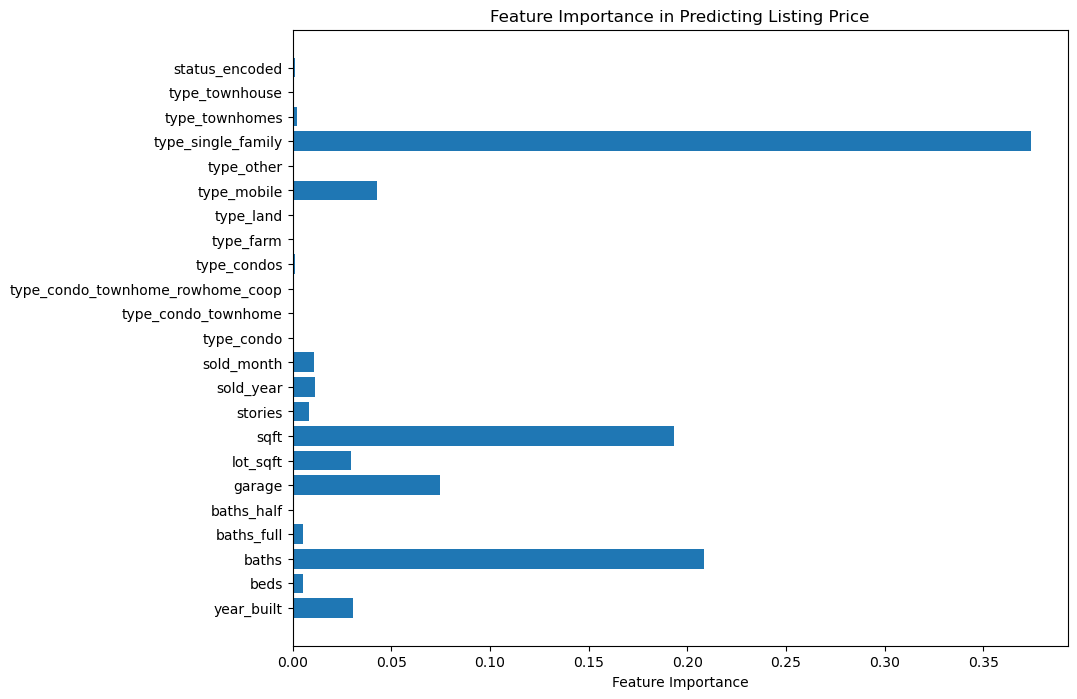

In [33]:
# Extract feature importance for the gradient boosting
feature_importances = best_model.feature_importances_
features = X_train.columns

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Predicting Listing Price")
plt.show()

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [36]:

# Set up a pipeline with scaling, feature engineering, and model tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Experiment with MinMaxScaler, RobustScaler if needed
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  # Optional, can tune degree
    ('model', GradientBoostingRegressor())
])


In [37]:

# Hyperparameters for tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.05],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0],
    'model__min_samples_split': [2, 5, 10]
}


In [38]:

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train_prepared, y_train)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test_prepared)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Gradient Boosting Model Performance:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   5.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   5.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   5.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   5.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   5.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_split=2, model__n_estimators=100, model__subsample=1.0; total time=   6.4s
[CV] END model__learning_rate=0.01, m

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compare baseline and improved R-squared
baseline_scores = {
    'Gradient Boosting (Before Tuning)': 0.6566920833557454,
    'Random Forest': 0.6196657954480231,
    'Ridge Regression': 0.5361082110017976
}
improved_scores = {
    'Gradient Boosting (After Tuning)': r2
}

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(baseline_scores.keys(), baseline_scores.values(), color='skyblue', label='Baseline Scores')
plt.bar(improved_scores.keys(), improved_scores.values(), color='salmon', label='Improved Scores')
plt.xlabel("Models")
plt.ylabel("R-squared Score")
plt.title("Model Performance Before and After Tuning")
plt.legend()
plt.show()


In [ ]:
# Scatter plot of predictions vs. actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Property Prices")
plt.show()
